In [51]:
#required imports

import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from dataclasses import dataclass
from typing import List, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

from scipy.constants import physical_constants, h

from qutip import jmat, tensor, identity, Qobj

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector

import warnings
warnings.filterwarnings("ignore")

# Finding Pulse Sequence

### Setting beginning and ending states
### setting desired U value

In [55]:
# defining starting state, both qutrits in (1 0 0) state to begin with

qubit1state=basis(3, 0)
qubit2state=basis(3, 0)
startingstate=tensor(qubit1state,qubit1state) #initial state
 #when you tensor things together in QuTIP in kepps the dimensions of the original object
    #so changing the dims just tells it we can actually use this as a 9x1 and not 2 3x3s.
startingstate.dims=[[9],[1]]
startingstate



Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [56]:
#definiting out unitary transofrmation input as a RX by pi for the first qubit
#to make the dimensions match we have to tensor it with the idetity 

U=tensor(rotation(jmat(1,'x'),np.pi),identity(3))
U.dims=[[9],[9]]# change dims again
U

#rotation in x about 

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 0.5+0.j          0. +0.j          0. +0.j          0. -0.70710678j
   0. +0.j          0. +0.j         -0.5+0.j          0. +0.j
   0. +0.j        ]
 [ 0. +0.j          0.5+0.j          0. +0.j          0. +0.j
   0. -0.70710678j  0. +0.j          0. +0.j         -0.5+0.j
   0. +0.j        ]
 [ 0. +0.j          0. +0.j          0.5+0.j          0. +0.j
   0. +0.j          0. -0.70710678j  0. +0.j          0. +0.j
  -0.5+0.j        ]
 [ 0. -0.70710678j  0. +0.j          0. +0.j          0. +0.j
   0. +0.j          0. +0.j          0. -0.70710678j  0. +0.j
   0. +0.j        ]
 [ 0. +0.j          0. -0.70710678j  0. +0.j          0. +0.j
   0. +0.j          0. +0.j          0. +0.j          0. -0.70710678j
   0. +0.j        ]
 [ 0. +0.j          0. +0.j          0. -0.70710678j  0. +0.j
   0. +0.j          0. +0.j          0. +0.j          0. +0.j
   0. -0.70710678j]
 [-0.5+0.j          0. +0.j  

## Defining 3x3 pauli spin matrices 
## Definiting number of iterations
## Defining H_ops

In [30]:
R = 150 #GRAPE itterations

T = 1
times = np.linspace(0, T, 100)


#Defining some terms so the hamiltonian is more clear
#Elec qubit is first qubit, spin=1
#Nuc terms are second qubit, spin=1




nuclear_spin = 1
electron_spin = 1
sigmaxE = jmat(electron_spin,'x')
sigmayE = jmat(electron_spin,'y')
#print (sigmayE)
sigmazE = jmat(electron_spin,'z')
sigmaxN = jmat(nuclear_spin,'x')
sigmayN = jmat(nuclear_spin,'y')
sigmazN = jmat(nuclear_spin,'z')
sigmazEsquared = sigmazE*sigmazE
sigmazNsquared = sigmazN*sigmazN
identity3 = identity(3) #3x3 identity matrix

#we allowed the hamiltonian to tune every field 
H_opsEx=tensor(sigmaxE, identity3)
H_opsEy=tensor(sigmayE, identity3)
H_opsEz=tensor(sigmazE, identity3)



H_opsNx=tensor(identity3, sigmaxN)
H_opsNy=tensor(identity3, sigmayN)
H_opsNz=tensor(identity3, sigmazN)

H_opsENx = tensor(sigmaxE, sigmaxN)
H_opsENy = tensor(sigmayE, sigmayN)           
H_opsENz = tensor(sigmazE, sigmazN)
#print (H_opsENz)

#changing dims bc qutip is silly

H_opsEx.dims=[[9],[9]]
H_opsEy.dims=[[9],[9]]
H_opsEz.dims=[[9],[9]]

H_opsNx.dims=[[9],[9]]
H_opsNy.dims=[[9],[9]]
H_opsNz.dims=[[9],[9]]

H_opsENx.dims=[[9],[9]]
H_opsENy.dims=[[9],[9]]
H_opsENz.dims=[[9],[9]] 


#making H_ops list           
H_ops = [H_opsEx, H_opsEy, H_opsEz, H_opsNx, H_opsNy, H_opsNz, H_opsENx, H_opsENy, H_opsENz]            
               
               
#making labels for pulse sequence graphs
H_labels = [r'$uE_{x}$',
            r'$uE_{y}$',
            r'$uE_{z}$',
            r'$uN_{x}$',
            r'$uN_{y}$',
            r'$uN_{z}$',
            r'$uEN_{x}$',
            r'$uEN_{y}$',
            r'$uEN_{z}$']


# Defining hamiltonian and constants 

In [31]:



#witing out hamiltonian terms


H1 = tensor(0.1*pi*jmat(1,'z'), identity(3))

H2= tensor(identity(3), 0.1*pi*jmat(1,'z'))

H3= tensor(0.1*pi*jmat(1,'z'), 0.1*pi*jmat(1,'z'))
H0= H1+H2+H3

H0.dims=[[9],[9]]
H0 


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.72701457  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.31415927  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.09869604  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.31415927  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.31415927
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.09869604  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -0.31415927  0.        ]
 [ 0.          0.          0.          0.          0.         

# Plot pulses

In [32]:
##creating initial control pulse values as starting guess for GRAPE

u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10) / 10, u0[idx, :], mode='same') for idx in range(len(H_ops))]


In [33]:
#doing GRAPE!

result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0 , eps=2 * pi / T, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time:  10.22s. Est. time left: 00:00:01:31
20.0%. Run time:  22.03s. Est. time left: 00:00:01:28
30.0%. Run time:  34.70s. Est. time left: 00:00:01:20
40.0%. Run time:  48.33s. Est. time left: 00:00:01:12
50.0%. Run time:  60.24s. Est. time left: 00:00:01:00
60.0%. Run time:  70.75s. Est. time left: 00:00:00:47
70.0%. Run time:  82.57s. Est. time left: 00:00:00:35
80.0%. Run time:  93.57s. Est. time left: 00:00:00:23
90.0%. Run time: 106.07s. Est. time left: 00:00:00:11
Total run time: 117.23s


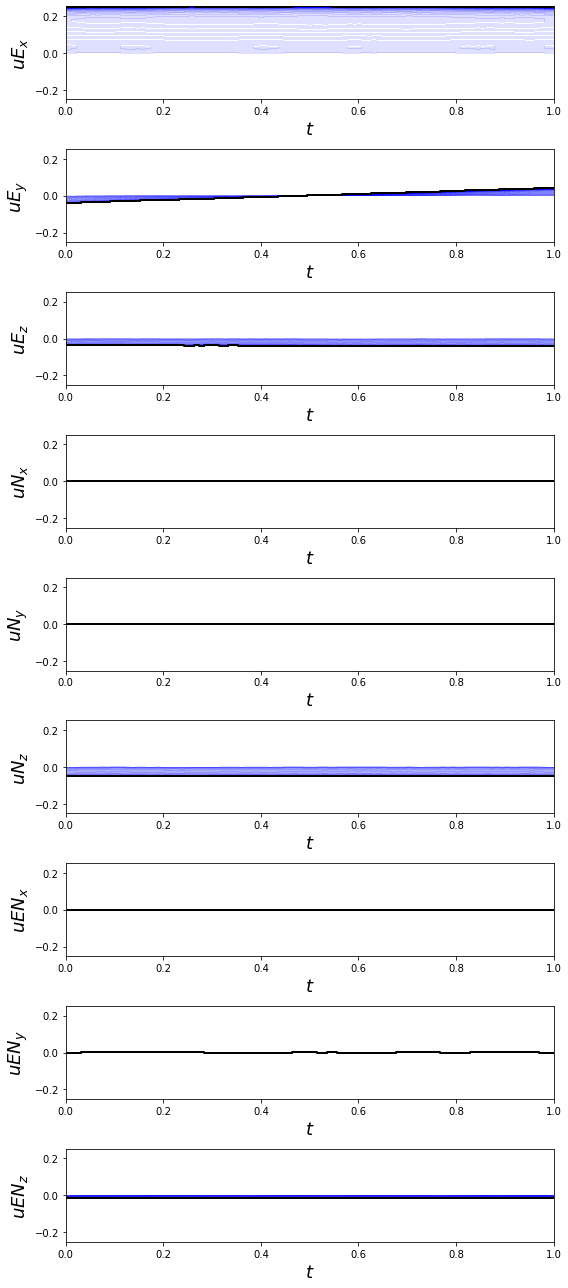

In [42]:
#Plotting GRAPE

plot_grape_control_fields(times, result.u[:, :, :] / (2 * pi), H_labels, uniform_axes=True);
plt.savefig("3level.jpeg")
plt.show()

# Calcuate fidelity

In [35]:
#printing ideal final state

idealfinalstate=U*startingstate
print (idealfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.5+0.j        ]
 [ 0. +0.j        ]
 [ 0. +0.j        ]
 [ 0. -0.70710678j]
 [ 0. +0.j        ]
 [ 0. +0.j        ]
 [-0.5+0.j        ]
 [ 0. +0.j        ]
 [ 0. +0.j        ]]


In [43]:
#printing GRAPE unitary tranfomation

result.U_f.tidyup(1e-4)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 5.00053302e-01-1.46195310e-04j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -1.61417189e-04-7.07106831e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -4.99946567e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  5.00005699e-01+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00-7.07106781e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -4.99994300e-01+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   4.99958684e-01+1.42124767e-04j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  1.58185517e-04-7.07106689e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -5.00041391e-01+0.00000000e+00j]
 [ 0.0000000

In [45]:
#printing real final state

realfinalstate=result.U_f*startingstate
print (realfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.5000533-1.46195310e-04j]
 [ 0.       +0.00000000e+00j]
 [ 0.       +0.00000000e+00j]
 [ 0.       -7.07106755e-01j]
 [ 0.       +0.00000000e+00j]
 [ 0.       +0.00000000e+00j]
 [-0.4999467+0.00000000e+00j]
 [ 0.       +0.00000000e+00j]
 [ 0.       +0.00000000e+00j]]


In [48]:
#finding density matrcies to find the fidelity

idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(realfinalstate * realfinalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)
fidelity(idealdensitymatrix,densitymatrix)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.25+0.j          0.  +0.j          0.  +0.j          0.  +0.35355339j
   0.  +0.j          0.  +0.j         -0.25+0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  -0.35355339j  0.  +0.j          0.  +0.j          0.5 +0.j
   0.  +0.j          0.  +0.j          0.  +0.35355339j  0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.

0.9996002791468257